In [1]:
using Flux, Plots, Colors, IJulia
using Base.Iterators: repeated
gr()

Plots.GRBackend()

### A univariate approximation problem  

We try to train a DNN to approximate the fermi-dirac function. Why? Just because this has been one of our standard examples...

In [ ]:
# This cell sets up the problem, the data and the ANN network structure 
beta = 10
trueFun(x) = [1/(1+exp(beta*x[1]))]

# Here we are taking measurements from the true model
# In real applications, we would just be given this 
# data rather than generate it ourselves
samples = [ [x] for x in range(-1, 1, length=1_000) ]
y = trueFun.(samples)

# This defines an ANN with an input layer, 
# two hidden layers with 10 nodes each and an output 
# layer (try Flux.sigmoid?)
nn = Chain(x -> x,                       # input layer
           Dense(1, 10, tanh),   # first hidden layer
           Dense(10, 10, tanh),  # second hidden layer 
           Dense(10, 10, tanh),  # third hidden layer 
           Dense(10, 1))                 # output layer


# errors at individual sample points 
sqerrors() = [sum(abs2, z) for z in y - Flux.data(nn.(samples))]
# loss functional => Least squares 
losssq() = sum(sqerrors())/length(samples)
# for plotting the errors 
errcols() = [sqrt(e.data) for e in sqerrors()]

# a call-back function to watch the optimisation...
function cb() #callback function to observe training
    # plot current prediction against data
    xp = [ x[1] for x in samples ]
    yx = [y[1] for y in y]
    yp = [ Flux.data(y[1]) for y in nn.(samples) ]
    IJulia.clear_output(true)
    P = plot(xp, yx, lw=2, label="exact")
    plot!(P, xp, yp, lw=2, label="ANN")
    title!(P,  "RMSE = $(sqrt(losssq().data))")
    display(P)
end

cb()

In [ ]:
# extract the parameters: 
# the weights w^{[n]} and shifts b^{[n]}
ps = Flux.params(nn)
# and now we can watch the training 
Flux.train!(losssq, ps, repeated((), 2_000), ADAM(0.05), cb = cb)

### Example 1: "Learning" a constitutive law
Our first example is to model a constitutive law for an ODE
$$
   \dot{u} = f(u)
$$
The exact law is 
$$
  f({\bf u}) = A {\bf u}^3,
$$
where ${\bf u} \in \mathbb{R}^2$, $A \in \mathbb{R}^{2 \times 2}$ and ${\bf u}^3$ means component-wise power.

Initially we will assume that we are able to just take measurements of $f$, i.e., for various sample points ${\bf u}$ we are able to evaluate $f({\bf u})$. This is not entirely a realistic setting, but it can get us started. 

In [ ]:
# This cell sets up the problem, the data 
# and the ANN network structure 
# -----------------------------------------
trueFun(u) = [-0.1 -0.1; -2.0 2.0] * u.^3

# Here we are taking measurements from the true model
# In real applications, we would just be given this 
# data rather than generate it ourselves
nsamples = 100
samples = [ rand(2) for n = 1:nsamples ]
y = trueFun.(samples)

# This defines an ANN with an input layer, 
# one hidden layer with 50 nodes and an output 
# layer   (try Flux.sigmoid?)
nn = Chain(x -> x,                       # input layer
           Dense(2, 10, Flux.sigmoid),   # first hidden layer
           Dense(10, 10, Flux.sigmoid),  # second hidden layer 
           Dense(10, 2))                 # output layer


# errors at individual sample points 
sqerrors() = [sum(abs2, z) for z in y - Flux.data(nn.(samples))]
# loss functional => Least squares 
losssq() = sum(sqerrors())/length(samples)
# for plotting the errors 
errcols() = [sqrt(e.data) for e in sqerrors()]

# a call-back function to watch the optimisation...
function cb() #callback function to observe training
    # plot current prediction against data
    x1 = [ x[1] for x in samples ]
    x2 = [ x[2] for x in samples ]
    err = errcols()
    IJulia.clear_output(true)
    display(scatter(x1, x2, zcolor=err, clims = (0.01, 0.1), label="", 
                    title = "RMSE = $(sqrt(losssq().data))", 
                    size = (400,350)))
end

cb()


In [ ]:
# extract the parameters: 
# the weights w^{[n]} and shifts b^{[n]}
ps = Flux.params(nn)
# and now we can watch the training 
Flux.train!(losssq, ps, repeated((), 2_000), ADAM(0.05), cb = cb)

In [ ]:
# Now produce contour plots of the two functions
x = range(0, 1, length=100)
X = [ [s, t]  for s in x for t in x]
Ftrue1 = [f[1] for f in trueFun.(X)]
Ftrue2 = [f[2] for f in trueFun.(X)]
Fann1 = [f.data[1] for f in nn.(X)]
Fann2 = [f.data[2] for f in nn.(X)]
Ptrue1 = contour(x, x, Ftrue1, clim=[-0.2,0.0], levels=27)
Ptrue2 = contour(x, x, Ftrue2, clim=[-0.2,0.0], levels=27)
Pann1 = contour(x, x, Fann1, clim=[-2.0,2.0], levels=27)
Pann2 = contour(x, x, Fann2, clim=[-2.0,2.0], levels=27)
plot(Ptrue1, Pann1, Ptrue2, Pann2)

In our final example we return to the ODE problem. But now we don't assume that we can evaluate the constitutive law directly, but we are only allowed to observe the trajectories!

In [ ]:
using Flux, DiffEqFlux, DifferentialEquations, Plots

u0 = Float32[2.; 0.]
datasize = 30
tspan = (0.0f0,1.5f0)

function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

t = range(tspan[1],tspan[2],length=datasize)
prob = ODEProblem(trueODEfunc,u0,tspan)
u = solve(prob,Tsit5()) 

# but we are only allowed to observe u at certain times t: 
ode_data = Array(solve(prob, Tsit5(), saveat=t))

plot(u)
scatter!(t, ode_data[1,:], c=1, label = "samples")
scatter!(t, ode_data[2,:], c=2, label = "samples")

In [ ]:

# specify the ANN: we are helping the ANN a bit 
# by giving the input layer some information about 
# the problem!
dudt = Chain(x -> x.^3,          # input layer
             Dense(2,50,tanh),   # one hidden layer
             Dense(50,2))        # output layer

ps = Flux.params(dudt)

# specify the ode-solver using the ANN as the 
# driving force => to return the approximation solution 
# at the sample points 
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat=t,
                      reltol=1e-7, abstol=1e-9)

function predict_n_ode()
  n_ode(u0)
end
loss_n_ode() = sum(abs2, ode_data .- predict_n_ode())

function cb() #callback function to observe training
  # plot current prediction against data
  cur_pred = Flux.data(predict_n_ode())
  IJulia.clear_output(true)
  pl = scatter(t,ode_data[1,:],c=1,label="data", title="loss=$(loss_n_ode().data)")
  scatter!(t,ode_data[2,:],c=2,label="data")
  scatter!(pl,t,cur_pred[1,:],c=1,m=:star,label="prediction")
  scatter!(pl,t,cur_pred[2,:],c=2,m=:star,label="prediction")
  display(pl)
end

# Display the ODE with the initial parameter values.
cb()

In [ ]:
Flux.train!(loss_n_ode, ps, repeated((), 1000), ADAM(0.05), cb = cb)

### Example 3: Classification

Our second class of examples are classification problem:  Given samples $y_m \in \{e_1, e_2\}$ at spatial locations $x_m \in [0,1]^2$ we are trying to find a function $y = f(x)$ such that $y_m \approx f(x_m)$. Note that it is common to use unit vectors $e_i$ to describe the different categories. For general points $x$, $f(x)$ will be a vector with mixed coordinates, which is information that we can use to give a confidence to the classification.

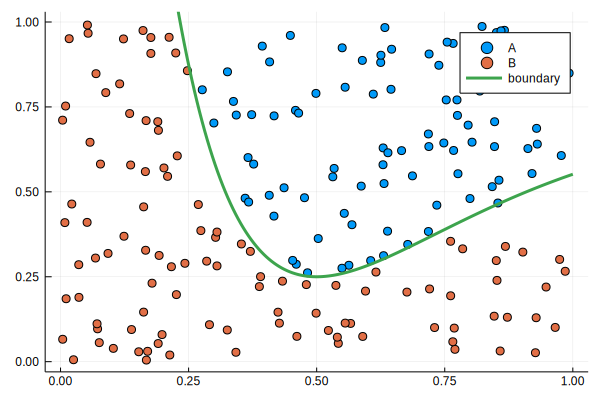

In [9]:
# define some curve that separates the data 
ff(x) = 0.5*(exp(-3*(x[1]-0.5)) - 1)^2+0.25
f(x) = x[2] - ff(x[1])
nsamples = 200 
samples = [ rand(2) for n = 1:nsamples ]
IA = findall(f.(samples) .> 0) 
IB = findall(f.(samples) .<= 0) 
x1 = [s[1] for s in samples]
x2 = [s[2] for s in samples]
xx = range(0, 1, length=200)
scatter(x1[IA], x2[IA], label="A")
scatter!(x1[IB], x2[IB], label="B")
plot!(xx, ff.(xx), lw=3, label="boundary", ylims=[0,1])

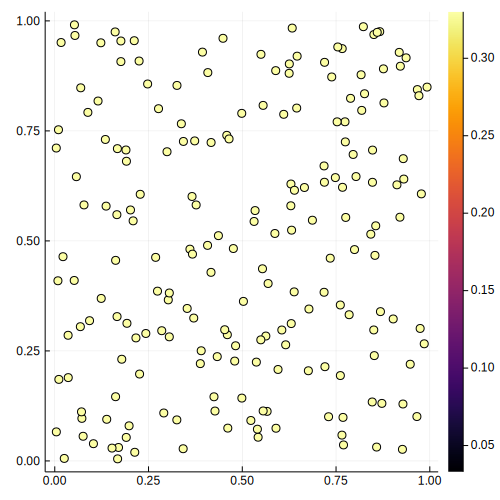

In [10]:
# prepare the sample data 
y = [ zeros(2) for _=1:nsamples ]
for n in IA; y[n] = [1.0,0.0]; end 
for n in IB; y[n] = [0.0,1.0]; end 

# defines ANN 
nn = Chain(x -> x,             # input layer
           Dense(2,10,Flux.sigmoid),   # first hidden layer
           Dense(10,10,Flux.sigmoid),   # second hidden layer
           Dense(10,2))        # second NN layer

# extract the parameters: 
# the weights w^{[n]} and shifts b^{[n]}
ps = Flux.params(nn)

# errors at individual sample points 
sqerrors() = [sum(abs2, z) for z in y - Flux.data(nn.(samples))]
# loss functional => Least squares 
losssq() = sum(sqerrors())/length(samples)
# for plotting the errors 
errcols() = [sqrt(e.data) for e in sqerrors()]

# a call-back function to watch the optimisation...
function cb() #callback function to observe training
    println("RMSE = $(sqrt(losssq().data))")
    # plot current prediction against data
    err = errcols()
    IJulia.clear_output(true)
    display(scatter(x1, x2, zcolor=err, clims = (0.033, 0.33), 
                    label="", size=(500,500)))
end

cb()

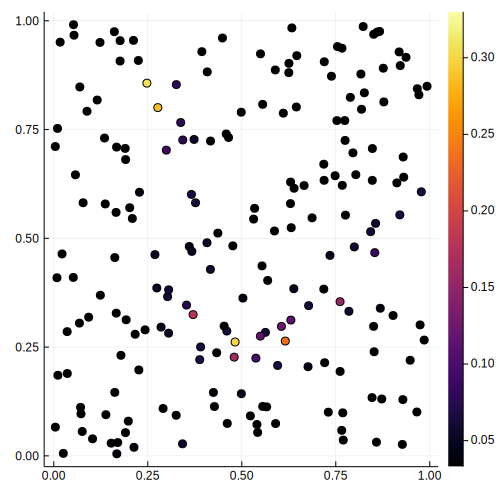

In [11]:
Flux.train!(losssq, ps, repeated((), 1_000), ADAM(0.05), cb = cb)

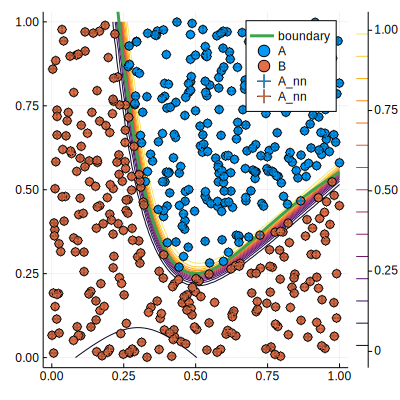

In [13]:
# create a test set 
nvalidate = 500
samples = [ rand(2) for n = 1:nvalidate ]
x1 = [s[1] for s in samples]
x2 = [s[2] for s in samples]
IA = findall(f.(samples) .> 0) 
IB = findall(f.(samples) .<= 0) 
y_nn = [y.data for y in nn.(samples)]
IA_nn = findall( [(abs(y[1]) > abs(y[2])) for y in y_nn] )
IB_nn = setdiff(1:length(y_nn), IA_nn)
t = range(0,1,length=100)
contour(t, t, (x,y) -> Flux.data(nn([x,y]))[1], label="nn",
        ylims=[0,1], size=(400,400))
plot!(xx, ff.(xx), label="boundary", c=3, lw=3)
scatter!(x1[IA], x2[IA], c=1, label="A")
scatter!(x1[IB], x2[IB], c=2, label="B")
scatter!(x1[IA_nn], x2[IA_nn], m=:cross, c = 1, label="A_nn")
scatter!(x1[IB_nn], x2[IB_nn], m=:cross, c = 2, label="A_nn")

### Example 4: Handwriting Recognition

As our final example we consider hand-writing recognition,
another fairly elementary classification problem.

In [2]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

# load images from MNIST database 
imgs = MNIST.images()
# and the corresponding classification
labels = MNIST.labels()
# show the first four images 
display(hcat(imgs[1:4]...))
println(labels[1:4])

[5, 0, 4, 1]


In [3]:
# Stack images into one large batch
# for faster processing...
X = hcat(float.(reshape.(imgs, :))...)
Y = onehotbatch(labels, 0:9)

# ANN : this network architecture is classical construction
#       I'm not sure why this is such a good choice?!
m = Chain(  # 28 x 28 pixel image as input
  Dense(28^2, 32, relu),  # hidden layer with max(0,x) activation 
  Dense(32, 10),          # output layer => 10 different digits
  softmax)                # apply soft-max to output to filter

# look up cross entropy loss functions
# in the documentation / any ANN tutorial
loss(x, y) = crossentropy(m(x), y)

# how many images are correctly classified?
accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

# a naive prediction implementation
predict(img) = findmax(m(float.(reshape(img, :))).data)[2]-1

predict (generic function with 1 method)

In [4]:
# pass in the whole dataset 200 times, i.e., 
# 200 training steps / optimisation steps 
dataset = repeated((X, Y), 200)
# call-back to show progress 
evalcb = () -> @show(loss(X, Y))
Flux.train!(loss, params(m), dataset, ADAM(), 
            cb = throttle(evalcb, 10))  # output progress only every 10 iterations
# display the accuracy of the fit 
accuracy(X, Y)

loss(X, Y) = 2.3349886f0 (tracked)
loss(X, Y) = 1.0296056f0 (tracked)
loss(X, Y) = 0.5687542f0 (tracked)
loss(X, Y) = 0.4224849f0 (tracked)
loss(X, Y) = 0.35592014f0 (tracked)
loss(X, Y) = 0.31659335f0 (tracked)
loss(X, Y) = 0.28967577f0 (tracked)
loss(X, Y) = 0.26873943f0 (tracked)


0.9262666666666667

,,,,,,,,,

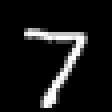
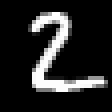
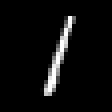
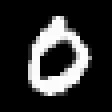
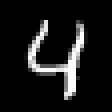
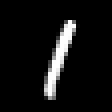
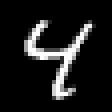
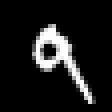
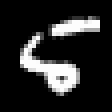
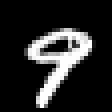

In [5]:
using Images
# test set 
MNIST.images(:test)[1:10]

In [6]:
# Accuracy on the test set is comparable with the training set!
tX = hcat(float.(reshape.(MNIST.images(:test), :))...)
tY = onehotbatch(MNIST.labels(:test), 0:9)
accuracy(tX, tY)

0.9282

,,,,,,,,,

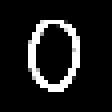
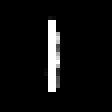
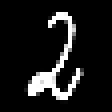
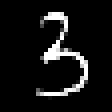
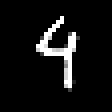
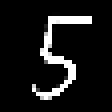
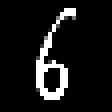
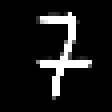
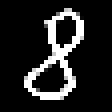
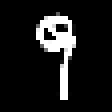

In [7]:
# now let's try to load some handwriting and see how we do!
# Convert to grayscale at loading 
using FileIO, Images 
imgs = [ Gray.(1 .- Gray.(load("digits/$n.png"))) for n = 0:9 ]

In [8]:
# check the predictions!
for n = 0:9 
    println("n = $n => ", predict(imgs[n+1]))
end

n = 0 => 0
n = 1 => 1
n = 2 => 2
n = 3 => 3
n = 4 => 9
n = 5 => 5
n = 6 => 6
n = 7 => 2
n = 8 => 3
n = 9 => 3
